In [1]:
import pandas as pd
import DataLoading
import NN_classes
import torch
import matplotlib.pyplot as plt
import numpy as np
import NN_evaluation

In [2]:
sc = "sc01"
period = "2030"
folder = "../Data/9n_AC_12w_ext_o_dummy_LCOE/"
all_executions = DataLoading.list_executions(folder=folder,per = period,sc=sc)
te_s = 0.3
val_s = 0.4
dfs_in, dfs_out, dfs_inter = DataLoading.load_data_ext_out(folder, all_executions, period, sc, ["PowerFlow"],"SystemCosts")
dfs_inter_j = DataLoading.join_frames_inter_layer(dfs_inter)
dfs_inter_j = DataLoading.trim_columns_to_common(dfs_inter_j)
# Convert to pytorch tensors
ts_in, ts_out, ts_inter = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, dfs_inter_j, all_executions, te_s, val_s)
d_ft_in, d_ft_out, d_ft_inter,maxs = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, ts_inter, all_executions)

input_size = dfs_in["Network_Existing_Generation_Full"].shape[1]
inter_size = dfs_inter_j["Network_Existing_Generation_Full"].shape[1]

input_f_sc01_Network_Existing_Generation_Full_2030.csv
24
input_f_sc01_Network_Line_In_Node_1_Node_6_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_2_Node_3_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_2_Node_6_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_3_Node_4_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_3_Node_6_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_4_Node_5_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_4_Node_6_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_4_Node_9_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_6_Node_7_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_6_Node_8_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_7_Node_8_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_8_Node_9_cac1_2030.csv
24


In [3]:
#hyperloop_name = "RTS24_AC_12w_dummy_0.3_v0.4_PF_LCOE_0_40"
hyperloop_name = "3-bus_AC_12w_dummy_0.3_v0.4_PF_LCOE_0_10"
hyperloop_name = "9n_AC_12w_dummy_0.3_v0.4_PF_LCOE_0_13"
cluster_run = True

if cluster_run:
    df_losses = pd.read_csv(f"ResultsClusterRuns/Loss_results_csv/{hyperloop_name}.csv",index_col=0)
else:
    df_losses = pd.read_csv(f"Loss_results_csv/{hyperloop_name}.csv",index_col=0)


[48, 18, 12]


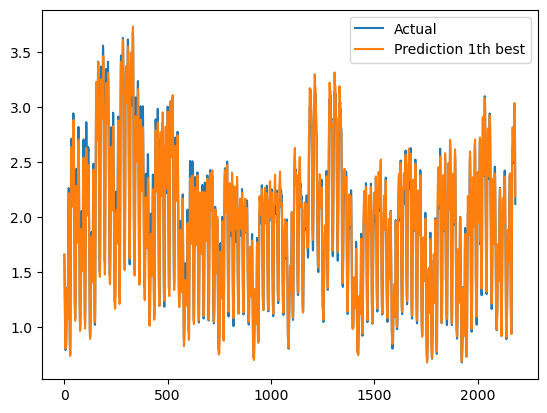

In [11]:
#Visualisation of multiple models in input order

f = df_losses.Np == 0


loss_to_sort = "Te_l_mae"

ex = all_executions[10]

ex_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
ex_out = dfs_out[ex].sum(axis=1).to_numpy()

s = 0
e=s+2500
plt.plot(ex_out[s:e],label = "Actual")

for xth_best in [1]: 
    row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
    m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=cluster_run)
    prediction = m(ex_in.float())[0].detach().numpy()
    plt.plot(prediction[s:e],label = f"Prediction {xth_best}th best")
plt.legend()

In [6]:
i=0
all_counts = pd.DataFrame()

for ex in all_executions:
    ex_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
    lb_actual = dfs_out[ex].sum(axis=1).to_numpy().flatten()
    
    lb_est =  m(ex_in.float())[0].detach().numpy().flatten()
    
    both_positive_count = np.sum((lb_est > 0) & (lb_actual > 0))
    both_negative_count = np.sum((lb_est < 0) & (lb_actual < 0))
    opposite_sign_count = np.sum((lb_est * lb_actual) < 0)
    BZ = np.sum((lb_est==0) & (lb_actual == 0))
    OZ = np.sum((lb_est * lb_actual) == 0)


    row_lb = pd.DataFrame({"exec":ex,"BP":both_positive_count, "BN":both_negative_count,"OS":opposite_sign_count,"OZ":OZ,"BZ":BZ,}, index = [i])
    all_counts = pd.concat([all_counts,row_lb],axis=0)
    i+=1
    

In [7]:
all_counts.sum()

exec    Network_Existing_Generation_FullNetwork_Line_I...
BP                                                  28266
BN                                                      0
OS                                                      0
OZ                                                    126
BZ                                                      0
dtype: object

In [42]:
#calculate loss manually to see if coherent 

data_part = "test"
loss = torch.nn.MSELoss()

prediction = m(d_ft_in[data_part].float())[0]
loss(prediction.squeeze(),d_ft_out[data_part])

tensor(5.7853e-09, dtype=torch.float64, grad_fn=<MseLossBackward0>)

In [40]:
manual_loss_mse = np.mean([(p.item()-a)**2  for p,a in zip(prediction.squeeze(),d_ft_out[data_part])])
manual_loss_mae = np.mean(np.abs([(p.item()-a)  for p,a in zip(prediction.squeeze(),d_ft_out[data_part])]))

In [41]:
manual_loss_mse,manual_loss_mae

(5.785276570340915e-09, 5.5119475880945136e-05)

In [22]:
prediction.squeeze()

tensor([1.1114e-04, 1.1932e-04, 1.1292e-04,  ..., 2.3428e-06, 2.9865e-04,
        3.4909e-04], grad_fn=<SqueezeBackward0>)